Import useful standard modules. Note that geopandas is not included standard with Anaconda.

In [1]:
# Some fairly standard modules
import os, csv, lzma
import numpy as np
import matplotlib.pyplot as plt

# The geopandas module does not come standard with anaconda,
# so you'll need to run the anaconda prompt as an administrator
# and install it via "conda install -c conda-forge geopandas".
# That installation will include pyproj and shapely automatically.
# These are useful modules for plotting geospatial data.
import geopandas as gpd
import pyproj
import shapely.geometry

# These modules are useful for tracking where modules are
# imported from, e.g., to check we're using our local edited
# versions of open_cp scripts.
import sys
import inspect
import importlib

# In order to use our local edited versions of open_cp
# scripts, we insert the parent directory of the current
# file ("..") at the start of our sys.path here.
sys.path.insert(0, os.path.abspath(".."))

# Elements from PredictCode's custom "open_cp" package
import open_cp.sources.chicago as chicago
import open_cp.sources.ukpolice as ukpolice

# Confirm we're using local versions of code
print(inspect.getfile(chicago))
print(inspect.getfile(ukpolice))


C:\Users\Dustin\Documents\GitHub\PredictCode\open_cp\sources\chicago.py
C:\Users\Dustin\Documents\GitHub\PredictCode\open_cp\sources\ukpolice.py


Declare location of data directory for Chicago data.

In [2]:
datadir = os.path.join("..", "..", "Data")
chicago.set_data_directory(datadir)

Read data from CSV or CSV.XZ file, view first couple rows.

In [3]:
def get_csv_data(shortfilename="chicago.csv"):
    filename = os.path.join(datadir, shortfilename)
    if shortfilename.endswith(".csv.xz"):
        with lzma.open(filename, "rt") as f:
            yield from csv.reader(f)
    elif shortfilename.endswith(".csv"):
        with open(filename, "rt") as f:
            yield from csv.reader(f)
    else:
        yield None

rows = get_csv_data("chicago.csv")
print(next(rows))
print(next(rows))

['CASE#', 'DATE  OF OCCURRENCE', 'BLOCK', ' IUCR', ' PRIMARY DESCRIPTION', ' SECONDARY DESCRIPTION', ' LOCATION DESCRIPTION', 'ARREST', 'DOMESTIC', 'BEAT', 'WARD', 'FBI CD', 'X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION']
['JB241987', '04/28/2018 10:05:00 PM', '009XX N LONG AVE', '2092', 'NARCOTICS', 'SOLICIT NARCOTICS ON PUBLICWAY', 'SIDEWALK', 'Y', 'N', '1524', '37', '18', '1140136', '1905903', '41.897894893', '-87.760743714', '(41.897894893, -87.760743714)']


Obtain polygon shapely object for South side of Chicago via custom "get_side" function.

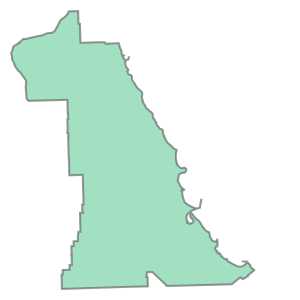

In [4]:
polygon = chicago.get_side("South")
polygon

Declare geopandas GeoDataFrame object named "South Side", set its geometry equal to the shapely polygon we obtained from the Chicago data, and set its Coordinate Reference System (CRS) to epsg:2790.

In [5]:
frame = gpd.GeoDataFrame({"name":["South Side"]})
frame.geometry = [polygon]
frame.crs = {"init":"epsg:2790"}
frame

,name,geometry
0,South Side,"POLYGON ((365647.3845872784 565208.9811670227,..."


Save geopandas GeoDataFrame object as a "file" that can be reloaded later (actually a directory containing a set of corresponding files).

Note that this currently generates a warning about part of the fiona module being deprecated.

In [6]:
frame.to_file("SouthSide")

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Obtain default burglary data from Chicago data directory. Takes the form of custom object TimedPoints.

In [7]:
points = chicago.default_burglary_data()
print(type(points))

<class 'open_cp.data.TimedPoints'>


View some initial features: size of data, earliest and latest times, size of bounding box for spatial data, and the aspect ratio of that bounding box.

In [8]:
print("Number of timestamps: " + str(len(points.timestamps)))
print("Earliest time: " + str(points.time_range[0]))
print("Latest time: " + str(points.time_range[1]))
bbox = points.bounding_box
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)
print("Aspect ratio: " + str(bbox.aspect_ratio))


Number of timestamps: 63792
Earliest time: 2018-02-12T06:00:00.000
Latest time: 2019-02-11T23:39:00.000
X coord range: 333057.45491490985 367317.9578359157
Y coord range: 552876.9113538227 594816.256032512
Aspect ratio: 1.224131028531268


Plot points

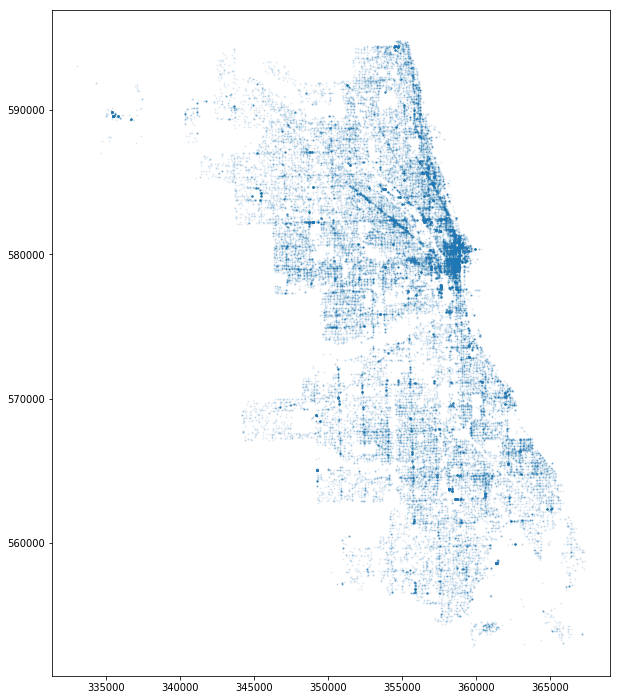

In [9]:
_, ax = plt.subplots(figsize=(10,10 * bbox.aspect_ratio))
ax.scatter(points.coords[0], points.coords[1], alpha=0.1, marker="o", s=1)

Focus on region of downtown.

X coord range: 355000.0508001016 360394.41198882397
Y coord range: 575004.5212090424 584996.7995935992


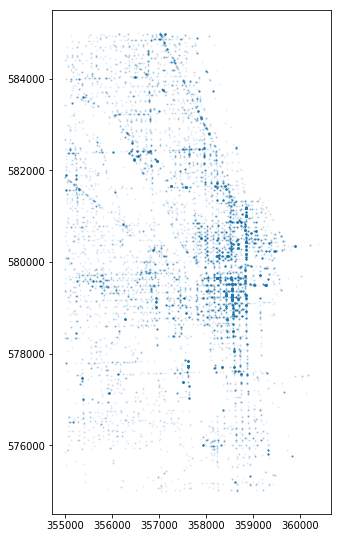

In [10]:
mask = ( (points.xcoords >= 355000) & (points.xcoords <= 365000) &
        (points.ycoords >= 575000) & (points.ycoords <= 585000) )

downtown = points[mask]

bbox = downtown.bounding_box
print("X coord range:", bbox.xmin, bbox.xmax)
print("Y coord range:", bbox.ymin, bbox.ymax)
_, ax = plt.subplots(figsize=(5, 5 * bbox.aspect_ratio))
ax.scatter(downtown.coords[0], downtown.coords[1], alpha=0.1, marker="o", s=1)

# UK Data

This example uses data from January 2017, West Yorkshire. The csv file is expected to be titled "ukpolice.csv" and located in the current directory. (Not the data_dir as in the Chicago data.)

In [11]:
points = ukpolice.default_burglary_data()
len(points.timestamps)

2358

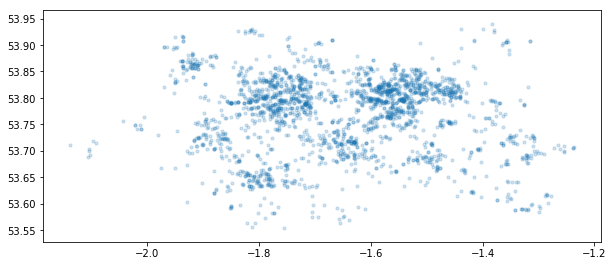

In [12]:
bbox = points.bounding_box
_, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(points.xcoords, points.ycoords, s=10, alpha=0.2)

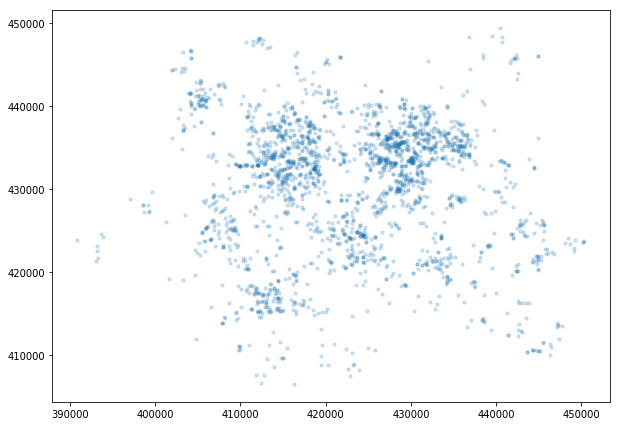

In [14]:
import open_cp
projected_points = open_cp.data.points_from_lon_lat(points, epsg=7405)
bbox = projected_points.bounding_box
_, ax = plt.subplots(figsize=(10, 10 * bbox.aspect_ratio))
ax.scatter(projected_points.xcoords, projected_points.ycoords, s=10, alpha=0.2)